توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation


در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [ ]:
import numpy as np


def displacement(img):
    rows, cols = img.shape[:2]

    # Define a random displacement
    disp_x = np.random.randint(-20, 20)
    disp_y = np.random.randint(-20, 20)

    # Create a translation matrix
    M = np.float32([[1, 0, disp_x], [0, 1, disp_y]])

    # Apply translation to the image with border replication
    displaced_img = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)

    return displaced_img

def rotation(img):
    rows, cols = img.shape[:2]

    # Define a random rotation angle
    angle = np.random.randint(-30, 30)

    # Create a rotation matrix
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)

    # Apply rotation to the image with border replication
    rotated_img = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)

    return rotated_img

def scaling(img):
    rows, cols = img.shape[:2]

    # Define random scaling factors
    scale_x = np.random.uniform(0.8, 1.2)
    scale_y = np.random.uniform(0.8, 1.2)

    # Create a scaling matrix
    M = np.float32([[scale_x, 0, 0], [0, scale_y, 0]])

    # Apply scaling to the image with border replication
    scaled_img = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)

    return scaled_img


# function 4
def brightness(img):
    # Define a random brightness factor
    brightness_factor = np.random.uniform(0.5, 1.5)

    # Apply brightness adjustment
    brightened_img = img * brightness_factor
    brightened_img = np.clip(brightened_img, 0, 255).astype(np.uint8)

    return brightened_img

# function 5
def blurring(img):
    # Apply random blurring
    kernel_size = np.random.choice([3, 5, 7])
    blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    return blurred_img

# function 6
def gaussian_noise(img):
    # Apply random Gaussian noise
    noise = np.random.normal(0, 10, img.shape)
    noisy_img = img + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)

    return noisy_img


In [ ]:
from torch.utils.data import Dataset, DataLoader
import glob
import os
from PIL import Image
import torchvision.transforms.functional as F

class CustomDataset(Dataset):
    def __init__(self, data_path, dataType=1, augN=1): # dataType: Train=1, Val=2, Test=3
        self.data_path = data_path
        self.dataType = dataType
        self.image_list = self.get_image_list()
        self.N = len(self.image_list)
        self.augN = 1 if dataType != 1 else augN

    def get_image_list(self):
        if self.dataType == 1:
            folder_path = os.path.join(self.data_path, 'ADEChallengeData2016', 'images', 'training')
        elif self.dataType == 2:
            folder_path = os.path.join(self.data_path, 'ADEChallengeData2016', 'images', 'validation')
        elif self.dataType == 3:
            folder_path = os.path.join(self.data_path, 'release_test', 'testing')
        else:
            folder_path = os.path.join(self.data_path, 'release_test', 'testing')

        image_list = glob.glob(os.path.join(folder_path, '*.jpg'))
        return image_list

    def __getitem__(self, idx):
        main_idx = idx % self.N
        img_path = self.image_list[main_idx]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        # Apply augmentations for training set
        if main_idx != idx:

            # Randomly select an augmentation function
            aug_func = np.random.choice([brightness, blurring, gaussian_noise])

            # Apply the selected augmentation function
            img = aug_func(img)

        # label generation
        main_img = img
        label = random.randint(0, 7)
        out = [0, 0, 0]
        for i, func in enumerate([displacement, rotation, scaling]):
            if label & (1 << i):
                img = func(img)
                out[i] = 1

        return main_img, img, out

    def __len__(self):
        return len(self.image_list) * self.augN


As requeseted we are going to explain how is the data generation in our implementation:

our needed dataset for train,val,test is generated by CustomDataset class. 

in this class we first set the approperate dataset file for train or validation or test by dataType.

then for each image in the selected dataset,if its training we first performe one of augmentaion functions (the 3 last functions) and then perform 0,1 or 2 of the main functions (displacement, rotaion and scaling) and set the corresponding label which is a binary vector with size = 3 which indicate the main functions that has been applied to image. at the end the image and its label is read for our loader.

In [ ]:
def collate_fn(batch):
    return batch

In [ ]:
# Specify the path where the data is stored
data_path = '/content'  # Update with the actual path

# Create instances of the dataset for training, testing, and validation
dataset_train = CustomDataset(data_path, dataType=True, augN=5)
dataset_test = CustomDataset(data_path, dataType=False)
dataset_val = CustomDataset(data_path, dataType=False)

# Create data loaders with the custom collate function
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4, collate_fn=collate_fn)


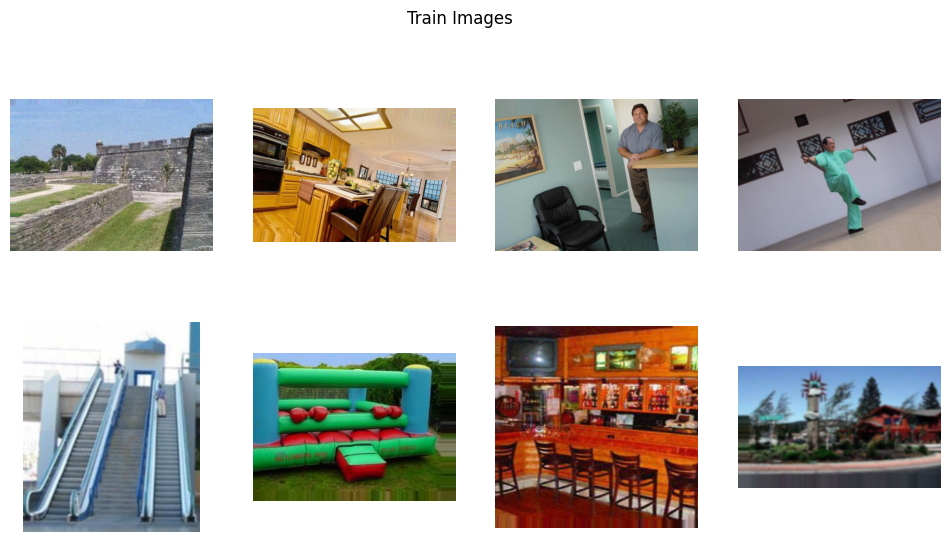

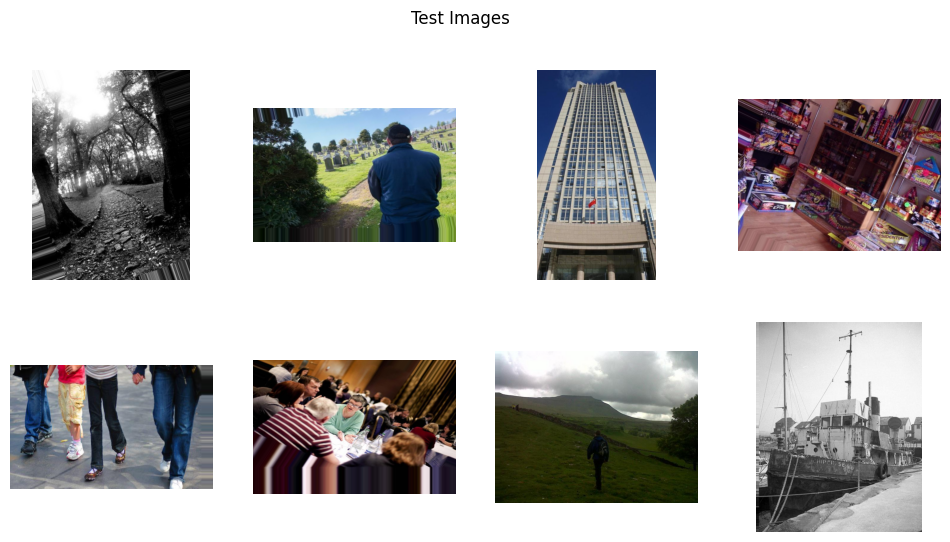

In [ ]:
# Show 8 images from train_loader and test_loader
def show_images(loader, title):
    try:
        data_iter = iter(loader)
        images = next(data_iter)
    except StopIteration:
        print(f"No more batches in the loader: {title}")
        return

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(title)

    for i in range(8):
        ax = axes[i // 4, i % 4]
        img = images[i][1]

        # If the image is a PyTorch tensor, convert it back to PIL Image
        if isinstance(img, torch.Tensor):
            img = F.to_pil_image(img)

        ax.imshow(img)
        ax.axis('off')

    plt.show()

# Show images from train_loader
show_images(train_loader, title='Train Images')

# Show images from test_loader
show_images(test_loader, title='Test Images')

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

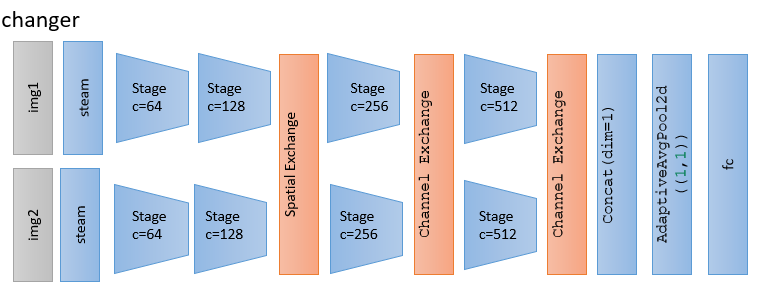

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


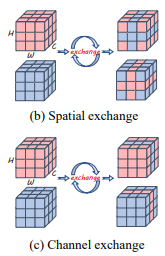

In [ ]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

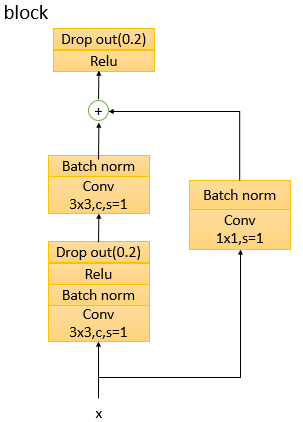

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





In [ ]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Block, self).__init__()

        # Convolutional block - Path 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )

        # Convolutional block - Path 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )

        # Final ReLU and Dropout
        self.final_relu_dropout = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )

    def forward(self, x):
        out1 = self.conv_block1(x)
        out2 = self.conv_block2(x)
        out = out1 + out2
        out = self.final_relu_dropout(out)
        return out

# Example usage:
# block = Block(in_channels=64, out_channels=128)
# output = block(torch.randn(1, 64, 224, 224))  # Assuming input size is 224x224 and 64 channels


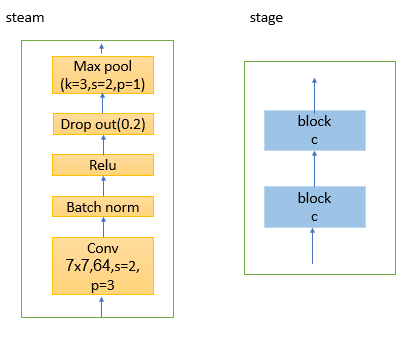

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [ ]:
import torch.nn as nn

class changer(nn.Module):
    def __init__(self, block, SpatialExchange, ChannelExchange):
        super(changer, self).__init__()

        self.steam = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.stage1 = self._make_stage(block, in_channels=64, out_channels=64)
        self.stage2 = self._make_stage(block, in_channels=64, out_channels=128)
        self.stage3 = self._make_stage(block, in_channels=128, out_channels=256)
        self.stage4 = self._make_stage(block, in_channels=256, out_channels=512)

        self.spatial_exchange = SpatialExchange()
        self.channel_exchange = ChannelExchange()

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 3)  # Assuming 3 classes

    def _make_stage(self, block, in_channels, out_channels):
        layers = [block(in_channels, out_channels), block(out_channels, out_channels)]
        return nn.Sequential(*layers)

    def forward(self, x1, x2):
        x1 = self.steam(x1)
        x2 = self.steam(x2)

        x1 = self.stage1(x1)
        x2 = self.stage1(x2)

        x1 = self.stage2(x1)
        x2 = self.stage2(x2)

        x1, x2 = self.spatial_exchange(x1, x2)

        x1 = self.stage3(x1)
        x2 = self.stage3(x2)

        x1, x2 = self.channel_exchange(x1, x2)

        x1 = self.stage4(x1)
        x2 = self.stage4(x2)

        x1, x2 = self.channel_exchange(x1, x2)

        # Concatenate
        concatenated_features = torch.cat([x1, x2], dim=1)

        # Global average pooling
        x = self.global_avg_pool(concatenated_features)

        # Flatten and pass through fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = changer(Block, SpatialExchange, ChannelExchange).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
for inp in train_loader:
    print(len(inp))


NameError: ignored

NameError: ignored

##Train & validation


In [ ]:

Loss_train = []
Loss_val = []

# Training loop
epochs = 10

for epoch in range(epochs):
    model.train()
    sum_loss = 0.0
    num_correct_train = 0

    for inputs1, inputs2, labels in train_loader:
        inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs1, inputs2)

        # Calculate loss
        loss = criterion(outputs, labels)
        sum_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Count correct predictions for training accuracy
        _, predicted = torch.max(outputs, 1)
        num_correct_train += (predicted == labels).sum().item()

    # Validation
    model.eval()
    loss_val = 0.0
    num_correct_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            # Forward pass (no optimization here)
            outputs_val = model(inputs_val)

            # Calculate validation loss
            loss_val += criterion(outputs_val, labels_val).item()

            # Count correct predictions for validation accuracy
            _, predicted_val = torch.max(outputs_val, 1)
            num_correct_val += (predicted_val == labels_val).sum().item()

    avg_loss_train = sum_loss / len(train_loader)
    avg_loss_val = loss_val / len(val_loader)

    Loss_train.append(avg_loss_train)
    Loss_val.append(avg_loss_val)

    print(f'Epoch {epoch + 1}/{epochs}, Loss_TRAIN: {avg_loss_train:.3f}, Acc_TRAIN: {num_correct_train / len(train_loader.dataset):.3f}, Loss_VAL: {avg_loss_val:.3f}, Acc_VAL: {num_correct_val / len(val_loader.dataset):.3f}')


ValueError: ignored

#Test


In [ ]:
checkpoint = torch.load('#To Do')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test

print(f' loss_test= {:.3f}, acc_test={()}')


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟